In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from tqdm import tqdm

In [2]:
# defininf the states
# defininsg coefficeients sybols

def Creating_states(coeff, Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])

In [3]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrix

M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix


In [4]:
#Creating function for the deltarho error

def experiment_rho(N, coeff, priors, POVM_elts, M_inv):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
    
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    return error

100%|██████████| 1000/1000 [02:39<00:00,  6.25it/s]


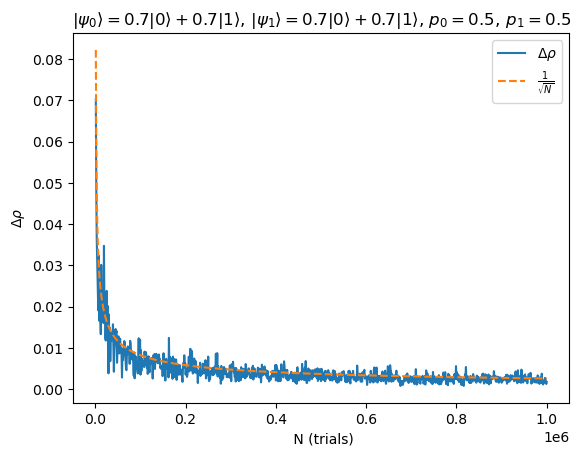

Error Converged to:  0.005688391819208718


In [5]:

coeff = [1/(2**.5),1/(2**.5),1/(2**.5),1/(2**.5)] #1/(2**.5)
priors = [.5,.5]
trials = [1000*(i+1) for i in range(1000)]

sqrtN  = [2.6/(i**.5) for i in trials]     # ideal square root shape with a constant multiplied for scaling
errors = [experiment_rho(i,coeff,priors,POVM_elts, M_inv) for i in tqdm(trials)]

plt.plot(trials, errors, label=r'$\Delta \rho $')
plt.plot(trials ,sqrtN, "--", label=r'$\frac{1}{\sqrt{N}}$')
plt.xlabel(' N (trials)')
plt.ylabel(r'$\Delta \rho $')
plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={},\,p_1={}$'.format(round(coeff[0],1), round(coeff[1],1), round(coeff[2],1), round(coeff[3],1), priors[0], priors[1]))
plt.legend()

plt.show()

print(f'Error Converged to: ' , experiment_rho( 1000*100 ,coeff,priors,POVM_elts, M_inv))

In [8]:
#Creating function for the fidelity error

def solve_quadratic(a, b, c):

    dis = b * b - 4 * a * c 
    sqrt_val = m.sqrt(abs(dis))

    if dis > 0: 
        sol1 = (-b - sqrt_val)/(2 * a)
        sol2 = (-b + sqrt_val)/(2 * a)
     
    elif dis == 0: 
        sol1 = -b / (2 * a)
        sol2 = -b / (2 * a)
     
    # when discriminant is less than 0
    else:
        sol1 = - b / (2 * a) - 1j*sqrt_val/ (2 * a)
        sol2 = - b / (2 * a) + 1j*sqrt_val/ (2 * a)
    

    return sol1, sol2

def experiment_fid(N, coeff, priors, POVM_elts, M_inv, thresh):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [i.real for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num = np.add(rho_num, matrix)       # created the numerical rho
     
    eigenvalues, eigenvectors = np.linalg.eig(rho_num) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    index = np.argmin(evals)
    eigenvector = eigenvectors[:,index]

    c00=eigenvector[0]
    c01=eigenvector[1]
    c01t=eigenvector[1]/m.sqrt(2)
    c11=eigenvector[2]

    f0,f1=solve_quadratic(c00, 2*c01t, c11)
    f0p,f1p=solve_quadratic(c11, 2*c01t, c00)


    csi = np.asarray([c00,c01,c11])
    csi0 = abs(np.vdot(csi,psi0psi0))**2
    csi1 = abs(np.vdot(csi,psi1psi1))**2
    csis = [csi0,csi1]

    if psi0[0]>=0:
        a0 = abs(f0)/(m.sqrt(1+ (abs(f0))**2))
        a0p = abs(f0p)/(m.sqrt(1+ (abs(f0p))**2))
    elif psi0[0]<0:
        a0 = -abs(f0)/(m.sqrt(1+ (abs(f0))**2))
        a0p = -abs(f0p)/(m.sqrt(1+ (abs(f0p))**2))

    if psi0[1]>=0:
        a1 = 1/(m.sqrt(1+ (abs(f0))**2))
        a1p = 1/(m.sqrt(1+ (abs(f0p))**2))
    elif psi0[1]<0:
        a1 = -1/(m.sqrt(1+ (abs(f0))**2))
        a1p = -1/(m.sqrt(1+ (abs(f0p))**2))
    
    if psi1[0]>=0:
        b0 = abs(f1)/(m.sqrt(1+ (abs(f1))**2))
        b0p = abs(f1p)/(m.sqrt(1+ (abs(f1p))**2))
    elif psi1[0]<0:
        b0 = -abs(f1)/(m.sqrt(1+ (abs(f1))**2))
        b0p = -abs(f1p)/(m.sqrt(1+ (abs(f1p))**2))

    if psi1[1]>=0:
        b1 = 1/(m.sqrt(1+ (abs(f1))**2))
        b1p = 1/(m.sqrt(1+ (abs(f1p))**2))
    elif psi1[1]<0:
        b1 = -1/(m.sqrt(1+ (abs(f1))**2))
        b1p = -1/(m.sqrt(1+ (abs(f1p))**2))

    psi_num1 = [a0,a1]
    psi_num2 = [a1,a0]
    psi_num3 = [b0,b1]
    psi_num4 = [b1,b0]
    psi_num1p = [a0p,a1p]
    psi_num2p = [a1p,a0p]
    psi_num3p = [b0p,b1p]
    psi_num4p = [b1p,b0p]

    fid01 = abs(np.vdot(psi_num1,psi0))**2
    fid02 = abs(np.vdot(psi_num2,psi0))**2
    fid03 = abs(np.vdot(psi_num3,psi0))**2
    fid04 = abs(np.vdot(psi_num4,psi0))**2
    
    fid11 = abs(np.vdot(psi_num1,psi1))**2
    fid12 = abs(np.vdot(psi_num2,psi1))**2
    fid13 = abs(np.vdot(psi_num3,psi1))**2
    fid14 = abs(np.vdot(psi_num4,psi1))**2


    fid01p = abs(np.vdot(psi_num1p,psi0))**2
    fid02p = abs(np.vdot(psi_num2p,psi0))**2
    fid03p = abs(np.vdot(psi_num3p,psi0))**2
    fid04p = abs(np.vdot(psi_num4p,psi0))**2
    
    fid11p = abs(np.vdot(psi_num1p,psi1))**2
    fid12p = abs(np.vdot(psi_num2p,psi1))**2
    fid13p = abs(np.vdot(psi_num3p,psi1))**2
    fid14p = abs(np.vdot(psi_num4p,psi1))**2


    fid0 = np.max([fid01, fid01p, fid02, fid02p, fid03,fid03p, fid04, fid04p])
    fid1 = np.max([fid11, fid11p, fid12, fid12p, fid13, fid13p, fid14, fid14p])
    fid = [fid0,fid1]

    return([fid,csis,csi])

overlap = 0


100%|██████████| 1000/1000 [00:16<00:00, 60.42it/s]
c:\Users\camipolv\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


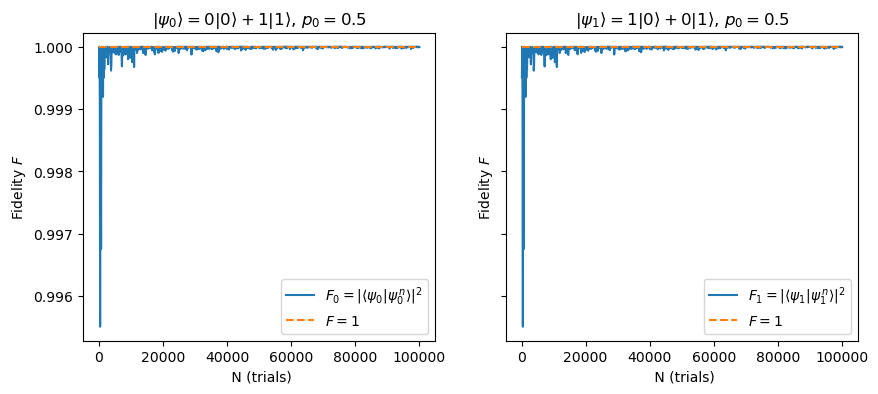

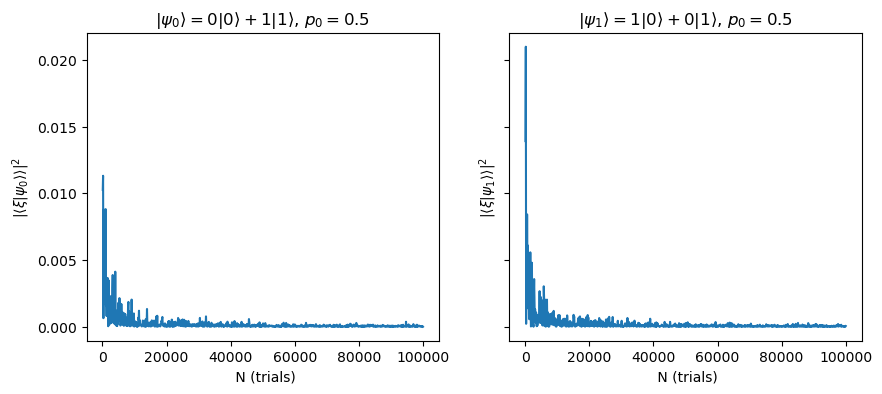

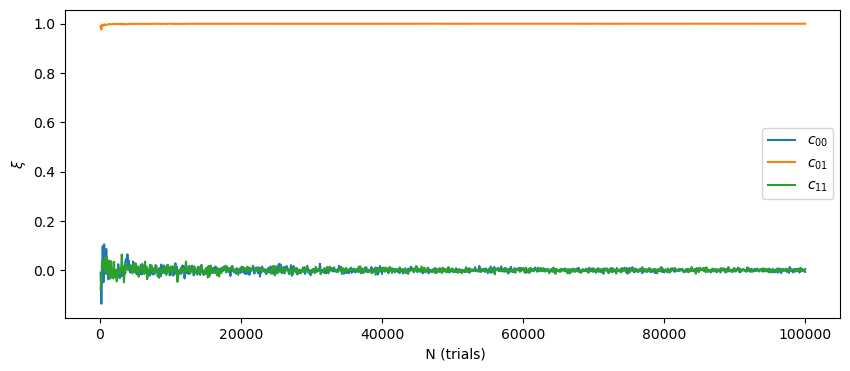

In [7]:
coeff = [0,1,1,0] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]
#trials = [10000,100000]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[2] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trials, outputc[0], label=r'$c_{00}$')
ax.plot(trials, outputc[1], label=r'$c_{01}$')
ax.plot(trials, outputc[2], label=r'$c_{11}$')

ax.set_xlabel(' N (trials)')
ax.set_ylabel(r'$\xi$')
#ax.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax.legend(loc='best')

plt.show()

overlap = 1


100%|██████████| 1000/1000 [00:16<00:00, 61.54it/s]


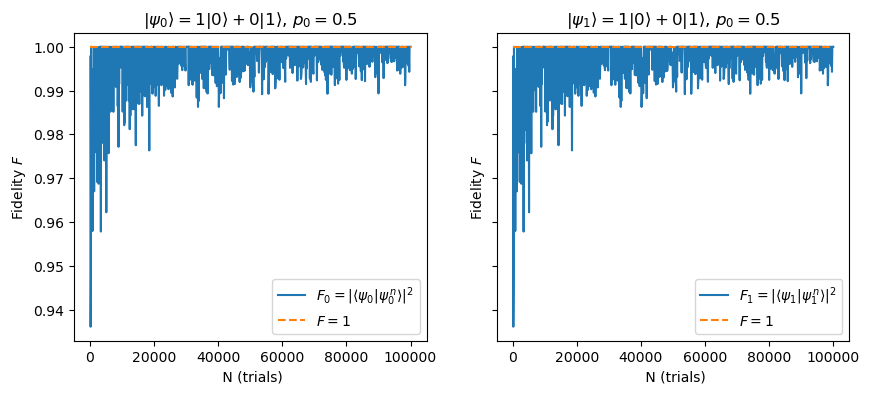

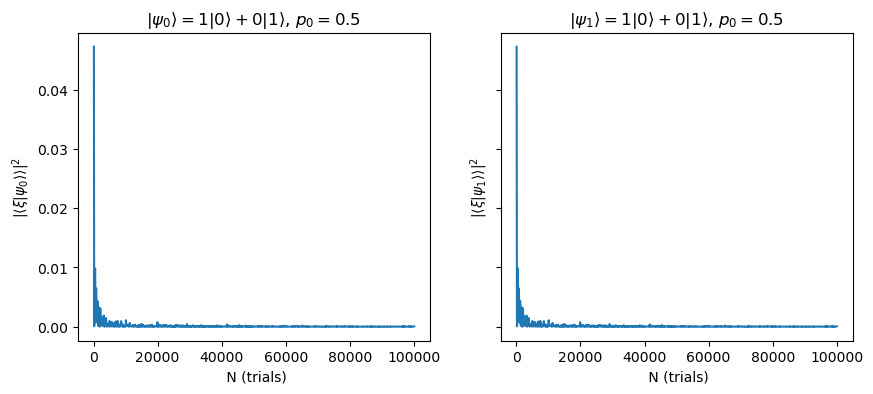

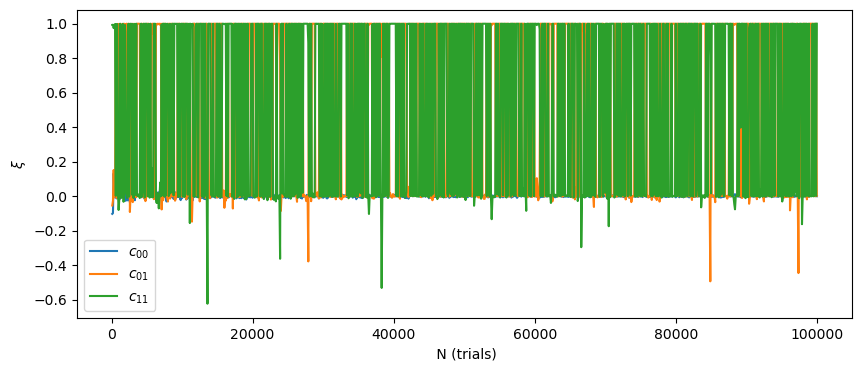

In [9]:
coeff = [1,0,1,0] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]
#trials = [10000,100000]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[2] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trials, outputc[0], label=r'$c_{00}$')
ax.plot(trials, outputc[1], label=r'$c_{01}$')
ax.plot(trials, outputc[2], label=r'$c_{11}$')

ax.set_xlabel(' N (trials)')
ax.set_ylabel(r'$\xi$')
#ax.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax.legend(loc='best')

plt.show()

overlap = 0.7071067811865475


100%|██████████| 1000/1000 [00:15<00:00, 62.90it/s]


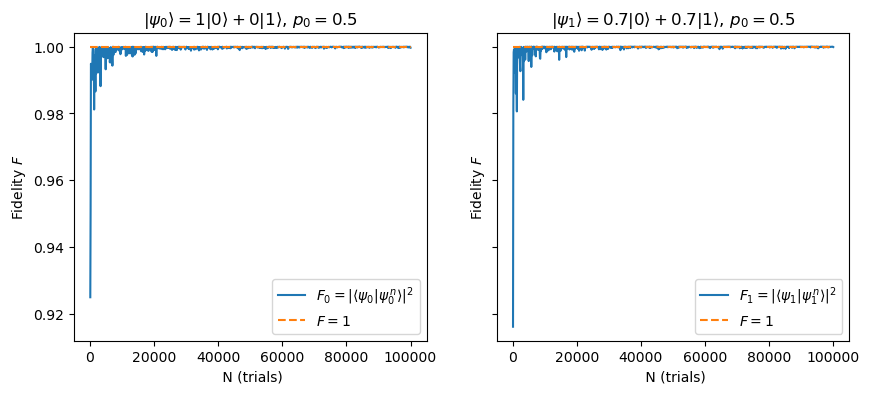

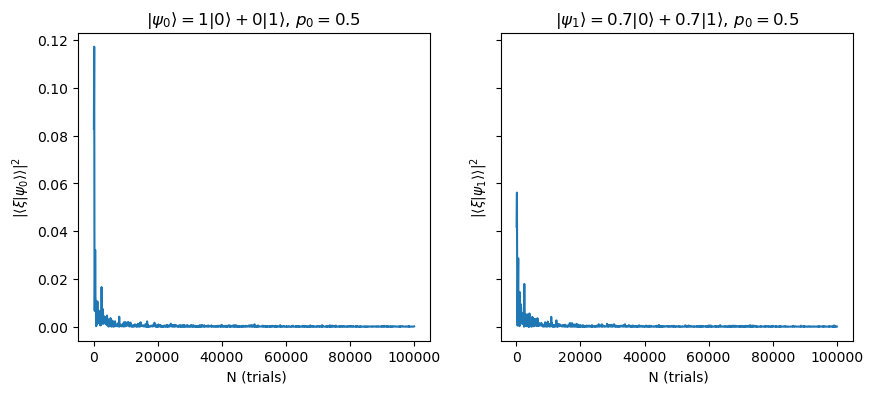

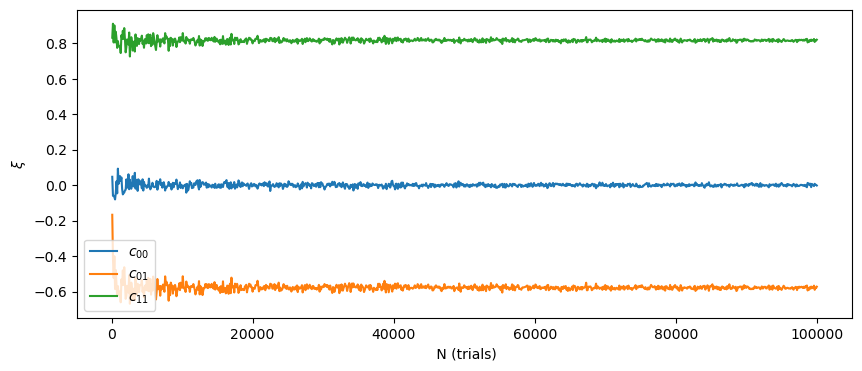

In [10]:
coeff = [1,0,1/(2**.5),1/(2**.5)] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]
#trials = [10000,100000]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[2] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trials, outputc[0], label=r'$c_{00}$')
ax.plot(trials, outputc[1], label=r'$c_{01}$')
ax.plot(trials, outputc[2], label=r'$c_{11}$')

ax.set_xlabel(' N (trials)')
ax.set_ylabel(r'$\xi$')
#ax.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax.legend(loc='best')

plt.show()

overlap = 1.0000000000000002


100%|██████████| 1000/1000 [00:15<00:00, 62.66it/s]


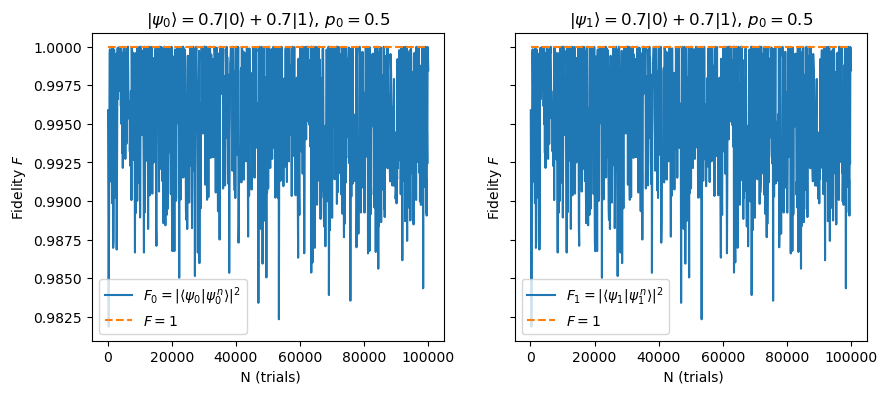

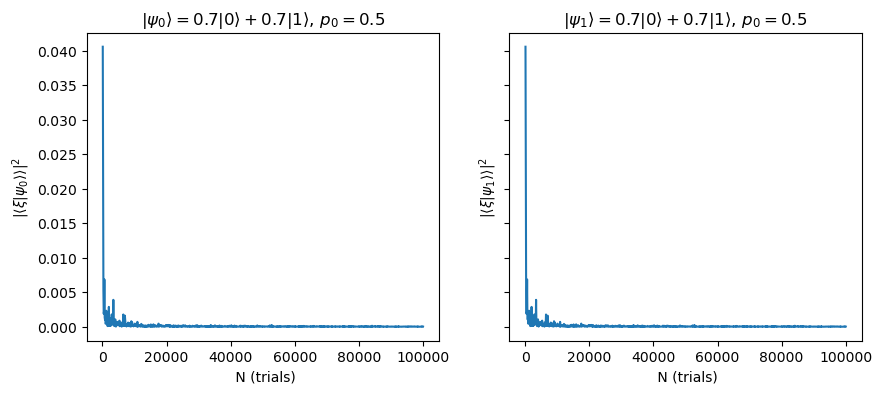

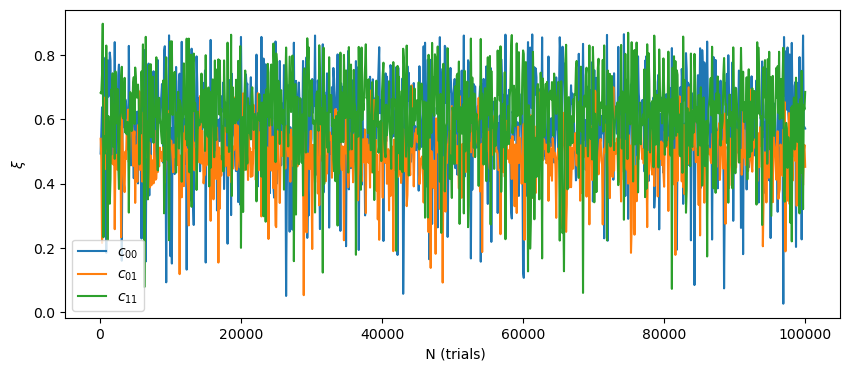

In [11]:
coeff = [(0.5)**(.5),(0.5)**(.5),(0.5)**(.5),(0.5)**(.5)] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]
#trials = [10000,100000]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[2] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c



fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trials, [abs(x) for x in outputc[0]], label=r'$c_{00}$')
#ax.plot(trials, outputc[0], label=r'$c_{00}$')
ax.plot(trials, [abs(x) for x in outputc[1]], label=r'$c_{01}$')
#ax.plot(trials, outputc[1], label=r'$c_{01}$')
ax.plot(trials, [abs(x) for x in outputc[2]], label=r'$c_{11}$')
#ax.plot(trials, outputc[2], label=r'$c_{11}$')

ax.set_xlabel(' N (trials)')
ax.set_ylabel(r'$\xi$')
#ax.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax.legend(loc='best')

plt.show()

overlap = 0.4472135954999579


100%|██████████| 1000/1000 [00:16<00:00, 59.94it/s]


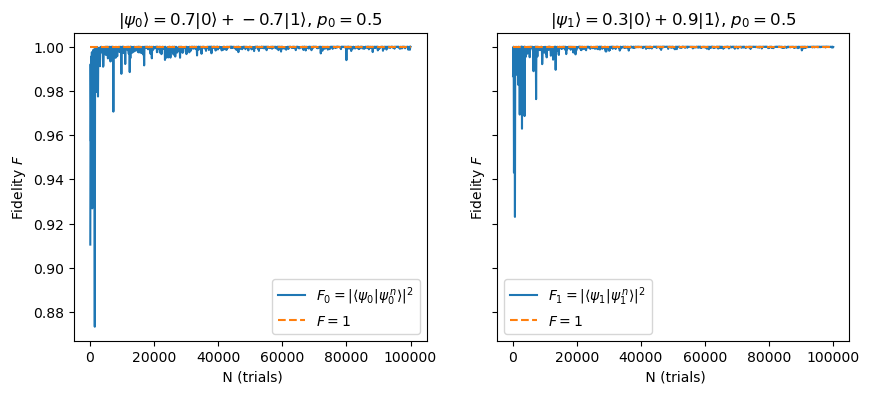

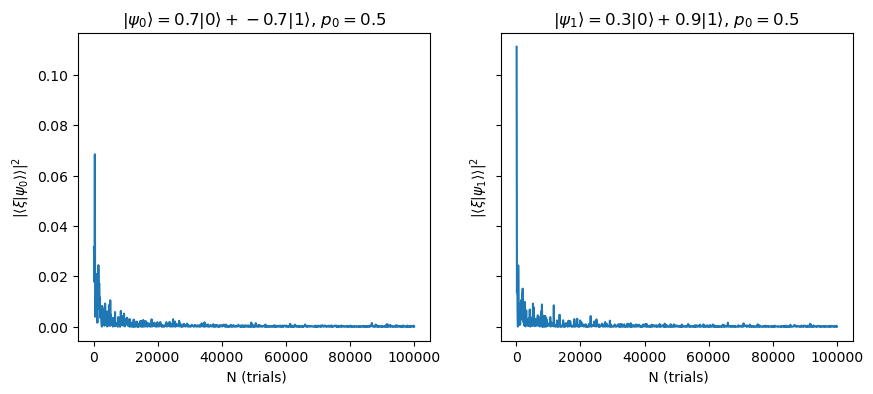

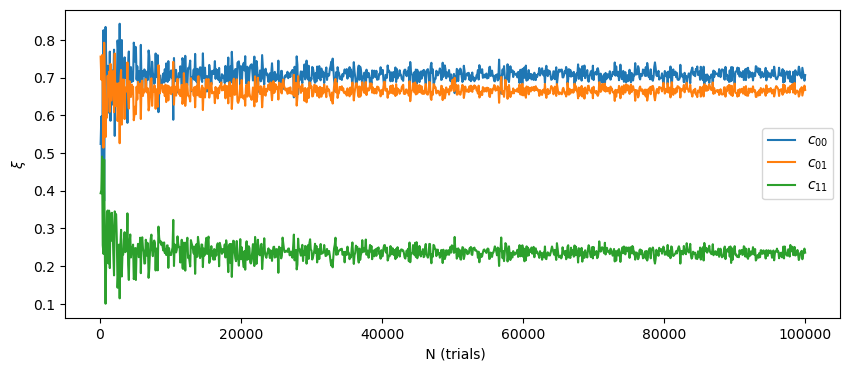

In [14]:
coeff = [(0.5)**(.5),-(0.5)**(.5),(0.1)**(.5),(0.9)**(.5)] 
priors = [.5,.5]
trials = [100*(i+1) for i in range(1000)]
#trials = [10000,100000]

initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
psi0 = initial_states[0]
psi1 = initial_states[1]
scalar = abs(np.vdot(psi0,psi1))
print(f'overlap = {scalar}')


pfid  = [1 for i in trials]    # perfect fidelity of 1
output_f = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[0] for i in tqdm(trials)]
output_x = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[1] for i in tqdm(trials)]
output_c = [experiment_fid(i,coeff,priors,POVM_elts, M_inv, 0.1)[2] for i in tqdm(trials)]
outputf = list(map(list, zip(*output_f))) # transpose of output_f
outputx = list(map(list, zip(*output_x))) # transpose of output_x
outputc = list(map(list, zip(*output_c))) # transpose of output_c


fig_a, (ax1a, ax2a) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1a.plot(trials, outputf[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
ax1a.plot(trials , pfid, "--", label=r'$F=1$')
ax1a.set_xlabel(' N (trials)')
ax1a.set_ylabel(r'Fidelity $F$')
ax1a.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
ax1a.legend(loc='best')

ax2a.plot(trials, outputf[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
ax2a.plot(trials , pfid, "--", label=r'$F=1$')
ax2a.set_xlabel(' N (trials)')
ax2a.set_ylabel(r'Fidelity $F$')
ax2a.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax2a.legend(loc='best')

fig_b, (ax1b, ax2b) = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax1b.plot(trials, outputx[0], label=r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
#ax1b.plot(trials , pfid, "--", label=r'$F=1$')
ax1b.set_xlabel(' N (trials)')
ax1b.set_ylabel(r'$|\langle \xi|\psi_0\rangle\rangle|^2$')
ax1b.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))
#ax1b.legend(loc='best')

ax2b.plot(trials, outputx[1], label=r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
#ax2b.plot(trials , pfid, "--", label=r'$F=1$')
ax2b.set_xlabel(' N (trials)')
ax2b.set_ylabel(r'$|\langle \xi|\psi_1\rangle\rangle|^2$')
ax2b.set_title(r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
#ax2b.legend(loc='best')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trials, [abs(x) for x in outputc[0]], label=r'$c_{00}$')
#ax.plot(trials, outputc[0], label=r'$c_{00}$')
ax.plot(trials, [abs(x) for x in outputc[1]], label=r'$c_{01}$')
#ax.plot(trials, outputc[1], label=r'$c_{01}$')
ax.plot(trials, [abs(x) for x in outputc[2]], label=r'$c_{11}$')
#ax.plot(trials, outputc[2], label=r'$c_{11}$')


ax.set_xlabel(' N (trials)')
ax.set_ylabel(r'$\xi$')
#ax.set_title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[0],1), round(coeff[1],1), priors[0]))r'$|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={}$'.format(round(coeff[2],1), round(coeff[3],1), priors[1]))
ax.legend(loc='best')

plt.show()